# Supplemental Notebook - NetColoc Optimization

Figures generated:
- SFigure 4A
- SFigure 4B
- SFigure 4C
- SFigure 4D

### Set Up

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import random as rn
import glob
import re
import matplotlib.colors as mcolors
cmapx = mcolors.LinearSegmentedColormap.from_list("my_cmap", ['#F5D1A0','#F08E02', '#BD6E01'])
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

In [153]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '../outputs')

In [150]:
cwd

'/cellar/users/snwright/Git/rare_common/Notebooks'

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon/inputs/testing/'
resdir= '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/QTesting2_BinTh/'

In [156]:
arial_font_path = os.path.join(cwd, '../Reference_Data/Arial.TTF')
fm.fontManager.addfont(arial_font_path)
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Identification of Optimization Traits

## Load Data

In [278]:
all_data = pd.read_csv(os.path.join(cwd, '../outputs/STable5.tsv'), sep='\t')
all_data['logp_size'] = all_data['COLOC P'].apply(lambda x: -1 * np.log10(x+ 1e-250))

## Evaluation Functions

In [289]:
def calculate_auc(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Calculate the AUC for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: AUC scores for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        y_true = group[control_col].apply(lambda x: 1 if x == control_labels[0] else 0)
        try:
            auc_score = roc_auc_score(y_true, group[value_col])
        except Exception as e:
            print(e)
            return y_true, group[value_col]
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'AUC': auc_score
        })
    
    return pd.DataFrame(results)


def perform_mann_whitney(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Perform Mann-Whitney U test for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: Mann-Whitney U test statistics and p-values for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        pos_scores = group[group[control_col] == control_labels[0]][value_col]
        neg_scores = group[group[control_col] == control_labels[1]][value_col]
        try:
            u_stat, p_value = mannwhitneyu(pos_scores, neg_scores, alternative='greater')
        except Error as e:
            print(e)
            return group, pos_scores, neg_scores
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'U_statistic': u_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)


def pair_auc(df1, df2, stats=['Mean_NPS', 'SizeOE', 'logp_size', 'logp_nps'], comp1='Group', comp2='Norm', 
             setcol='Set', pcol='logp_size', sizecol='log2SizeOE'):
    auc_res = []
    for stat in stats:
        shared_tests = set(df1[df1[setcol]=='Test'].testID.unique()).intersection(set(df2[df2[setcol]=='Test'].testID.unique()))
        shared_controls = set(df1[df1[setcol]=='Control'].testID.unique()).intersection(set(df2[df2[setcol]=='Control'].testID.unique()))
        n=len(shared_tests)
        #controls1 = df1[df1.Set=='Control'].sort_values('testID').iloc[0:2*n]
        #controls2 = df2[df2.Set=='Control'].sort_values('testID').iloc[0:2*n]
        df1 = pd.concat([df1[(df1.testID.isin(shared_tests))], df1[(df1.testID.isin(shared_controls))]])
        df2 = pd.concat([df2[(df2.testID.isin(shared_tests))], df2[(df2.testID.isin(shared_controls))]])
        test_df = pd.concat([df1, df2])
        if stat == pcol:
            test_df[pcol] = test_df.apply(lambda z: z[pcol] if z[sizecol]> 0 else -1 * z[pcol], axis=1)
        
        auc = calculate_auc(test_df, value_col=stat, processing_col=comp1, normalization_col=comp2, 
                                    control_col=setcol, control_labels=('Test', 'Control'))
        mannu = perform_mann_whitney(test_df, value_col=stat, processing_col=comp1, normalization_col=comp2, 
                                   control_col=setcol, control_labels=('Test', 'Control'))
        res = auc.merge(mannu, on=[comp1, comp2], how='outer')
        res['stat'] = stat
        auc_res.append(res)
    return pd.concat(auc_res), test_df

def plot_pair_auc(res_df, plot_df, ax=None, group='Group', stat='logp_size', group_col='Group', group2_col='Norm', 
                  color='lightgreen', text_p = False, text_n=False, setcol='Set'):
    sns.violinplot(plot_df[plot_df[group_col]==group], y=stat, x=group2_col, hue=setcol,cut=0, linewidth=0.5, 
                   palette=[color, 'grey'],  zorder=1, legend=False, ax=ax, saturation=1)
    for j, norm in enumerate(plot_df[group2_col].unique()):
        
        auc = float('%.3g' % res_df[(res_df[group_col]==group) & (res_df[group2_col]==norm) & (res_df.stat==stat)].AUC.values[0])
        if text_p:
            p = float('%.2g' % res_df[(res_df[group_col]==group) & (res_df[group2_col]==norm) & (res_df.stat==stat)].p_value.values[0])
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}\np:{p}', fontsize=7)
        elif text_n:
            n = int(plot_df[plot_df[group_col]==group].groupby(group2_col)[setcol].value_counts().values[0])
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}\nn={n}', fontsize=7)
        else:
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}', fontsize=7)
    if (stat == 'SizeOE') or (stat=='log2SizeOE'):
        _ = ax.set_yticks([-1, 0, 1, 2, 3], [0.5, 1, 2, 4, 8])
        _ = ax.set_yticks(np.log2([3,5,6,7]), minor=True)
    
    testId_counts =  plot_df[plot_df[group_col]==group].groupby(group2_col)[setcol].value_counts()
    minor_label = []
    for g in plot_df[plot_df[group_col]==group][group2_col].unique():
        for s in ['Test', 'Control']:
            minor_label.append(f'n={testId_counts[g][s]}')
    
    ax.set_xticks([-0.2,  0.2, 0.8, 1.2], labels=minor_label, minor=True)
    
    return plot_df[plot_df[group_col]==group]


## Bin and NPS Threshold Testing

### SFigure 4A -  Thresholds

In [182]:
th_data = all_data[all_data['Parameter Tested']=='th'].copy()
th_data['Threshold'] = [x for x in zip(th_data['T'], th_data['T*'])]

In [183]:
stats = ['log2COLOC Score', 'logp_size']
th_res = []
for stat in stats:
    th_data = th_data[th_data['Observed Size'] > 0]

    auc = calculate_auc(th_data, value_col=stat, processing_col='Threshold', normalization_col='NetColoc', 
                        control_col='TestControl', control_labels=('Test', 'Control'))
    mannu = perform_mann_whitney(th_data, value_col=stat, processing_col='Threshold', normalization_col='NetColoc', 
                               control_col='TestControl', control_labels=('Test', 'Control'))
    res = auc.merge(mannu, on=['Threshold', 'NetColoc'], how='outer')
    res['stat'] = stat
    th_res.append(res)
th_results = pd.concat(th_res)

In [184]:
th_results['ThZ'] = th_results.Threshold.apply(lambda x: x[1]) 
th_results['ThZZ'] = th_results.Threshold.apply(lambda x: x[0]) 
th_results['logp'] = np.log10(th_results.p_value) * -1

Text(0.5, 1.0, 'B-NetColoc')

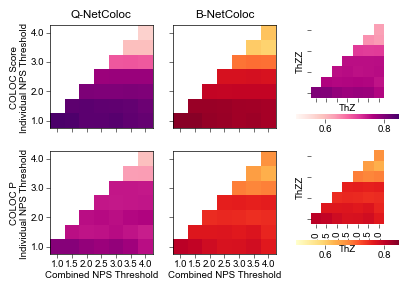

In [188]:
_, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(4.5, 3), sharex=True, sharey=True)

sns.heatmap(th_results[(th_results.stat=='log2COLOC Score') & (th_results.NetColoc=='Quantitative(Q)')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax1, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.NetColoc=='Quantitative(Q)')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax4, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[th_results.stat=='logp_size'].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax3, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=True,cbar_kws={'shrink':1, 'orientation':'horizontal'} )


sns.heatmap(th_results[(th_results.stat=='log2COLOC Score') & (th_results.NetColoc=='Binary(B)')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax2, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.NetColoc=='Binary(B)')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax5, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.NetColoc=='Binary(B)')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax6, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=True, cbar_kws={'shrink':1, 'orientation':'horizontal'})

for ax in [ax1, ax2, ax4, ax5]:
    for spine in ax.spines.values():
        spine.set_visible(True)      # Ensure the spine is visible         # Set the thickness of the border
        spine.set_edgecolor('black')
    ax.set_ylabel('')
    ax.set_xlabel('')

ax4.set_xlabel('Combined NPS Threshold')
ax5.set_xlabel('Combined NPS Threshold')
ax1.set_ylabel('COLOC Score\nIndividual NPS Threshold')
ax4.set_ylabel('COLOC P\nIndividual NPS Threshold')
ax1.tick_params(axis='y', rotation=0)
ax4.tick_params(axis='y', rotation=0)
ax1.set_title('Q-NetColoc')
ax2.set_title('B-NetColoc')
#plt.savefig(os.path.join(figdir, 'optimize_th_heatmaps.svg'), bbox_inches='tight')

### SFigure 4B - Bin Size

In [191]:
all_data.columns

Index(['Trait1', 'Trait2', 'TestControl', 'NetColoc', 'Parameter Tested',
       'Bin Size', 'T', 'T*', 'Observed Size', 'Expected Size',
       'log2COLOC Score', 'COLOC P', 'LenientOrStrict', 'SNP-to-Gene',
       'logp_size'],
      dtype='object')

In [190]:
bin_df = all_data[all_data['Parameter Tested']=='bin']

In [193]:
stats = ['log2COLOC Score', 'logp_size']
bin_res = []
for stat in stats:
    auc = calculate_auc(bin_df, value_col=stat, processing_col='Bin Size', normalization_col='NetColoc', 
                        control_col='TestControl', control_labels=('Test', 'Control'))
    mannu = perform_mann_whitney(bin_df, value_col=stat, processing_col='Bin Size', normalization_col='NetColoc', 
                               control_col='TestControl', control_labels=('Test', 'Control'))
    res = auc.merge(mannu, on=['Bin Size', 'NetColoc'], how='outer')
    res['stat'] = stat
    bin_res.append(res)
bin_results = pd.concat(bin_res)

In [197]:
bin_results

,Bin Size,NetColoc,AUC,U_statistic,p_value,stat,plotx
0,5,Binary(B),0.818053,1731.0,7.543160e-08,log2COLOC Score,0
1,5,Quantitative(Q),0.813800,1722.0,1.102182e-07,log2COLOC Score,0
2,10,Binary(B),0.830813,1758.0,2.349444e-08,log2COLOC Score,1
3,10,Quantitative(Q),0.828450,1753.0,2.925446e-08,log2COLOC Score,1
4,20,Binary(B),0.832703,1762.0,1.969338e-08,log2COLOC Score,2
5,20,Quantitative(Q),0.829395,1755.0,2.680270e-08,log2COLOC Score,2
6,40,Binary(B),0.817108,1729.0,8.209808e-08,log2COLOC Score,3
7,40,Quantitative(Q),0.821361,1738.0,5.597771e-08,log2COLOC Score,3
8,80,Binary(B),0.810019,1714.0,1.537828e-07,log2COLOC Score,4
9,80,Quantitative(Q),0.810964,1716.0,1.415461e-07,log2COLOC Score,4


/tmp/ipykernel_3604714/1512906727.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axa.set_yticklabels(['', 0.5, 1, 2, 4])


Text(0, 0.5, 'COLOC Score')

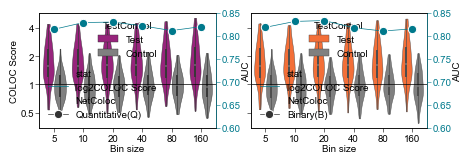

In [200]:
_, [axa, axb] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(5,1.5))

sns.violinplot(all_data[(all_data['Parameter Tested']=='bin') & (all_data['NetColoc']=='Quantitative(Q)')].reset_index(), 
               x='Bin Size', y='log2COLOC Score', hue='TestControl', cut=0,
              palette=['#97247C', 'grey'], ax=axa, saturation=1)
axa.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axa.set_xlim(-0.5, 5.5)
ax2 = axa.twinx()
bin_results['plotx'] = bin_results['Bin Size'].map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='log2COLOC Score') & (bin_results.NetColoc=='Quantitative(Q)')], 
             x='plotx', y='AUC', hue='stat', style='NetColoc', ax=ax2, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax2.set_ylim(0.6, 0.85)
ax2.tick_params(axis='y', colors='#00798C')
ax2.spines['right'].set_color('#00798C')
axa.set_xlabel('Bin size')
axa.set_ylabel('Log2 Size OE')
axa.set_yticklabels(['', 0.5, 1, 2, 4])


sns.violinplot(all_data[(all_data['Parameter Tested']=='bin') & (all_data['NetColoc']=='Binary(B)')].reset_index(), 
               x='Bin Size', y='log2COLOC Score', hue='TestControl', cut=0,
              palette=['#F36F38', 'grey'], ax=axb, saturation=1)
axb.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axb.set_xlim(-0.5, 5.5)
ax3 = axb.twinx()
bin_results['plotx'] = bin_results['Bin Size'].map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='log2COLOC Score') & (bin_results.NetColoc=='Binary(B)')], x='plotx', y='AUC', 
             hue='stat', style='NetColoc', ax=ax3, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax3.set_ylim(0.6, 0.85)
ax3.tick_params(axis='y', colors='#00798C')
ax3.spines['right'].set_color('#00798C')
axb.set_xlabel('Bin size')
axa.set_ylabel('COLOC Score')

#plt.savefig(os.path.join(figdir, 'optimize_bin_log2COLOC Score.svg'), bbox_inches='tight')

Text(0.5, 0, 'Bin size')

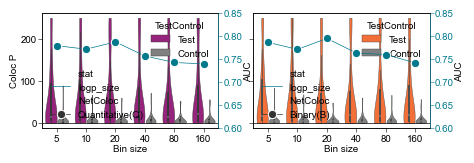

In [205]:
_, [axa, axb] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(5,1.5))

sns.violinplot(all_data[(all_data['Parameter Tested']=='bin') & (all_data['NetColoc']=='Quantitative(Q)')].reset_index(), 
               x='Bin Size', 
               y='logp_size', hue='TestControl', cut=0,
              palette=['#97247C', 'grey'], ax=axa, saturation=1)
axa.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axa.set_xlim(-0.5, 5.5)
ax2 = axa.twinx()
bin_results['plotx'] = bin_results['Bin Size'].map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='logp_size') & (bin_results.NetColoc=='Quantitative(Q)')], x='plotx', y='AUC', 
             hue='stat', style='NetColoc', ax=ax2, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax2.set_ylim(0.6, 0.85)
ax2.tick_params(axis='y', colors='#00798C')
ax2.spines['right'].set_color('#00798C')
axa.set_xlabel('Bin size')
axa.set_ylabel('Coloc P')


sns.violinplot(all_data[(all_data['Parameter Tested']=='bin') & (all_data['NetColoc']=='Binary(B)')].reset_index(), 
               x='Bin Size',
               y='logp_size', hue='TestControl', cut=0,
              palette=['#F36F38', 'grey'], ax=axb, saturation=1)
axb.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axb.set_xlim(-0.5, 5.5)
ax3 = axb.twinx()
bin_results['plotx'] = bin_results['Bin Size'].map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='logp_size') & (bin_results.NetColoc=='Binary(B)')], x='plotx', y='AUC', 
             hue='stat', style='NetColoc', ax=ax3, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax3.set_ylim(0.6, 0.85)
ax3.tick_params(axis='y', colors='#00798C')
ax3.spines['right'].set_color('#00798C')
axb.set_xlabel('Bin size')
#plt.savefig(os.path.join(figdir, 'optimize_bin_pval.svg'), bbox_inches='tight')

## S2G & p-value Threshold Testing

In [279]:
s2g_data = all_data[~all_data['Parameter Tested'].isin(['bin', 'th'])].copy()

In [280]:
s2g_data['testID'] = s2g_data.Trait1 + s2g_data.Trait2

In [281]:
s2g_data.columns

Index(['Trait1', 'Trait2', 'TestControl', 'NetColoc', 'Parameter Tested',
       'Bin Size', 'T', 'T*', 'Observed Size', 'Expected Size',
       'log2COLOC Score', 'COLOC P', 'LenientOrStrict', 'SNP-to-Gene',
       'logp_size', 'testID'],
      dtype='object')

In [282]:
all_data.groupby('LenientOrStrict')['SNP-to-Gene'].value_counts()

LenientOrStrict  SNP-to-Gene
Lenient          S2G            6408
                 MAGMA           211
Strict           MAGMA           186
                 S2G             120
Name: count, dtype: int64

In [283]:
s2g_data.groupby('LenientOrStrict')['SNP-to-Gene'].value_counts()

LenientOrStrict  SNP-to-Gene
Lenient          MAGMA          211
                 S2G            152
Strict           MAGMA          186
                 S2G            120
Name: count, dtype: int64

### SFigure 4C - Direct S2G

In [253]:
df1 = s2g_data[(s2g_data['SNP-to-Gene'] == 'S2G') & (s2g_data['LenientOrStrict']=='Lenient')]
df2 = s2g_data[(s2g_data['SNP-to-Gene'] == 'S2G') & (s2g_data['LenientOrStrict']=='Strict')]
shared_tests = set(df1.testID.unique()).intersection(set(df2.testID.unique()))
n=len(shared_tests)
controls1 = df1[df1.TestControl=='Control'].sort_values('testID').iloc[0:2*n]
controls2 = df2[df2.TestControl=='Control'].sort_values('testID').iloc[0:2*n]
df1 = pd.concat([df1[(df1.testID.isin(shared_tests))], controls1])
df2 = pd.concat([df2[(df2.testID.isin(shared_tests))], controls2])
auc = calculate_auc(pd.concat([df1, df2]), value_col='log2COLOC Score', processing_col='LenientOrStrict', 
                    normalization_col='NetColoc', 
                            control_col='TestControl', control_labels=('Test', 'Control'))
auc

,LenientOrStrict,NetColoc,AUC
0,Lenient,Binary(B),0.837288
1,Lenient,Quantitative(Q),0.836158
2,Strict,Binary(B),0.823729
3,Strict,Quantitative(Q),0.817514


In [290]:
ng_th, ng_th_df = pair_auc(s2g_data[(s2g_data['SNP-to-Gene'] == 'S2G') & (s2g_data['LenientOrStrict']=='Lenient')], 
                           s2g_data[(s2g_data['SNP-to-Gene'] == 'S2G') & (s2g_data['LenientOrStrict']=='Strict')],
                          setcol='TestControl', sizecol='log2COLOC Score', pcol='logp_size', comp1='LenientOrStrict', 
                           comp2='NetColoc', stats=['logp_size', 'log2COLOC Score'])


In [291]:
ng_th_df.groupby([ 'LenientOrStrict', 'NetColoc']).TestControl.value_counts()

LenientOrStrict  NetColoc         TestControl
Lenient          Binary(B)        Test           30
                                  Control        29
                 Quantitative(Q)  Test           30
                                  Control        29
Strict           Binary(B)        Test           30
                                  Control        29
                 Quantitative(Q)  Test           30
                                  Control        29
Name: count, dtype: int64

In [258]:
res_df= ng_th
res_df[(res_df.LenientOrStrict=='Lenient') & (res_df.NetColoc=='Binary(B)') & (res_df.stat=='logp_size')].AUC.values[0]

0.8448275862068966

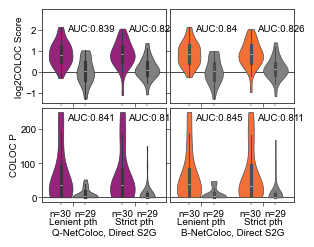

In [264]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(3.25,2.5), sharey='row', sharex=True, 
                                          gridspec_kw={'wspace':0.04, 'hspace':0.05})    

a = plot_pair_auc(ng_th, ng_th_df, ax=ax1, group='Quantitative(Q)', stat='log2COLOC Score', group2_col='LenientOrStrict', 
                  group_col='NetColoc', color='#97247C',setcol='TestControl')
plot_pair_auc(ng_th, ng_th_df, ax=ax2, group='Binary(B)', stat='log2COLOC Score', group2_col='LenientOrStrict', 
              group_col='NetColoc', color='#F36F38',setcol='TestControl')

plot_pair_auc(ng_th, ng_th_df, ax=ax3, group='Quantitative(Q)', stat='logp_size', group2_col='LenientOrStrict', 
              group_col='NetColoc', color='#97247C',setcol='TestControl')
plot_pair_auc(ng_th, ng_th_df, ax=ax4, group='Binary(B)', stat='logp_size', group2_col='LenientOrStrict', 
              group_col='NetColoc', color='#F36F38', setcol='TestControl')
for ax in [ax1, ax2, ax3, ax4]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nLenient pth', '\nStrict pth'])
for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 3)
    ax.set_yticks([-1, 0, 1, 2])

ax3.set_xlabel(f'Q-NetColoc, Direct S2G')
ax4.set_xlabel(f'B-NetColoc, Direct S2G')
#ax1.set_ylabel('Log2SizeOE')
_ = ax3.set_ylabel('COLOC P')
#plt.savefig(os.path.join(figdir, 'assocp_compare_ng.svg'), bbox_inches='tight')

### SFigure 4D - MAGMA

In [284]:
magma_th, magma_th_df = pair_auc(s2g_data[(s2g_data['SNP-to-Gene'] == 'MAGMA') & (s2g_data['LenientOrStrict']=='Lenient')], 
                                 s2g_data[(s2g_data['SNP-to-Gene'] == 'MAGMA') & (s2g_data['LenientOrStrict']=='Strict')],
                                setcol='TestControl', sizecol='log2COLOC Score', pcol='logp_size', comp1='LenientOrStrict', 
                           comp2='NetColoc', stats=['logp_size', 'log2COLOC Score'])

Text(0, 0.5, 'COLOC P')

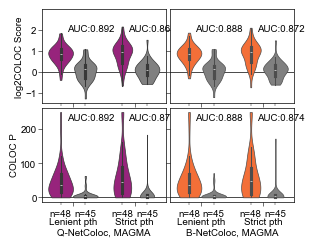

In [287]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(3.25,2.5), sharey='row', sharex=True, 
                                          gridspec_kw={'wspace':0.04, 'hspace':0.05})    

a = plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax1, group='Quantitative(Q)', stat='log2COLOC Score', 
                  group_col='NetColoc', group2_col='LenientOrStrict', color='#97247C', setcol='TestControl')
plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax2, group='Binary(B)', stat='log2COLOC Score', 
              group_col='NetColoc', group2_col='LenientOrStrict', color='#F36F38',setcol='TestControl')

a = plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax3, group='Quantitative(Q)', stat='logp_size', 
                  group_col='NetColoc', group2_col='LenientOrStrict', color='#97247C',setcol='TestControl')
plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax4, group='Binary(B)', stat='logp_size', 
              group_col='NetColoc', group2_col='LenientOrStrict', color='#F36F38',setcol='TestControl')
for ax in [ax1, ax2, ax3, ax4]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nLenient pth', '\nStrict pth'])
for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 3)
    ax.set_yticks([-1, 0, 1, 2])

ax3.set_xlabel('Q-NetColoc, MAGMA')
ax4.set_xlabel('B-NetColoc, MAGMA')
#ax1.set_ylabel('Log2SizeOE')
ax3.set_ylabel('COLOC P')
#plt.savefig(os.path.join(figdir, 'assocp_compare_magma.svg'), bbox_inches='tight')